In [1]:
import itertools
import time
from collections import defaultdict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix, csc_matrix, dok_matrix, lil_matrix

%matplotlib inline

# Load Freebase Datafile

Construct tensor (list of sparse matrix where each matrix represent a certain relation between entities) from triple dataset.

Maintaining the same tensor as a collection of csr matrices and csc matrices help to optimise time complexity.

In [2]:
def construct_freebase(shuffle = True):
    e_file = '../data/freebase/entities.txt'
    r_file = '../data/freebase/relations.txt'
    datafile = '../data/freebase/train_single_relation.txt'

    with open(e_file, 'r') as f:
        e_list = [line.strip() for line in f.readlines()]
    with open(r_file, 'r') as f:
        r_list = [line.strip() for line in f.readlines()]

    n_e = len(e_list) # number of entities
    n_r = len(r_list) # number of relations

    if shuffle:
        np.random.shuffle(e_list)
        np.random.shuffle(r_list)

    entities = {e_list[i]:i for i in range(n_e)}
    relations = {r_list[i]:i for i in range(n_r)}

    row_list = defaultdict(list)
    col_list = defaultdict(list)

    with open(datafile, 'r') as f:
        for line in f.readlines():
            start, relation, end = line.split('\t')
            rel_no = relations[relation.strip()]
            en1_no = entities[start.strip()]
            en2_no = entities[end.strip()]
            row_list[rel_no].append(en1_no)
            col_list[rel_no].append(en2_no)

    rowT = list()
    colT = list()
    for k in range(n_r):
        mat = csr_matrix((np.ones(len(row_list[k])), (row_list[k], col_list[k])), shape=(n_e, n_e))
        rowT.append(mat)
        mat = csc_matrix((np.ones(len(row_list[k])), (row_list[k], col_list[k])), shape=(n_e, n_e))
        colT.append(mat)
    return n_e, n_r, rowT, colT

## Growth of the number of triples with respect to the number of entities

First, we will see how the number of triples will be changed as we randomly add entities into tensor starting from zero entities.

In [3]:
n_triple = defaultdict(list)
n_sample = 3 # repeat counting n_sample times

for s in range(n_sample):
    tic = time.time()
    n_triple[0].append(0)    

    n_e, n_r, _rowT, _colT = construct_freebase()
    
    for i in range(1, n_e):
        # counting triples by expanding tensor
        cnt = 0
        for k in range(n_r):
            cnt += _rowT[k].getrow(i)[:,:i].nnz
            cnt += _colT[k].getcol(i)[:i-1,:].nnz            
        n_triple[i].append(n_triple[i-1][-1] + cnt)
        
    print(time.time()-tic)
avg_cnt = [np.mean(n_triple[i]) for i in range(n_e)]

488.675008058548
494.82316279411316
484.4668629169464


Size of tensor:

In [4]:
print(n_e**2*n_r)

73208874037


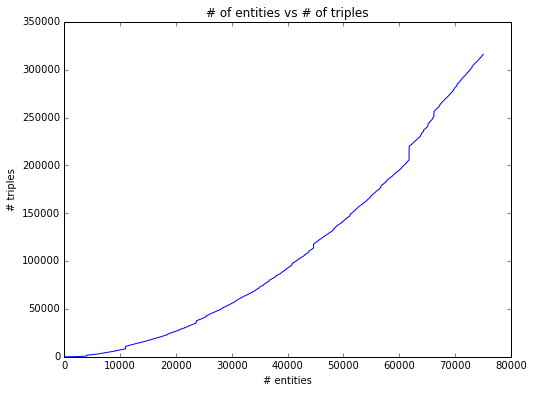

In [6]:
plt.figure(figsize=(8,6))
plt.plot(avg_cnt)
plt.title('# of entities vs # of triples')
plt.xlabel('# entities')
plt.ylabel('# triples')